In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR
from copy import deepcopy
import time 
from transformer import MultiHeadAttention, FeedForward, EncoderBlock, Encoder, DecoderBlock, Decoder, PositionalEncoding
import matplotlib.pyplot as plt

%matplotlib inline

## Blocks check

In [2]:
batch_size, length, dmodel, dk, dv, dff = 128, 28, 256, 32, 32, 1024
tensor = torch.randn(batch_size, length, dmodel)

model = MultiHeadAttention(dmodel=dmodel, dk=dk, dv=dv)
start = time.time()
curr = model(tensor, tensor, tensor, has_mask=True)
end = time.time()
end - start, curr.size()

(0.09028291702270508, torch.Size([128, 28, 256]))

In [3]:
model = FeedForward(dmodel=dmodel, dff=dff)
start = time.time()
curr = model(tensor)
end = time.time()
end - start, curr.size()

(0.07523012161254883, torch.Size([128, 28, 256]))

In [4]:
model = EncoderBlock(dmodel=dmodel, dk=dk, dv=dv, dff=dff)
start = time.time()
curr = model(tensor)
end = time.time()
end - start, curr.size()

(0.24800801277160645, torch.Size([128, 28, 256]))

In [5]:
model = Encoder(dmodel=dmodel, dk=dk, dv=dv, dff=dff)
start = time.time()
curr = model(tensor)
end = time.time()
end - start, curr.size()

(0.6160168647766113, torch.Size([128, 28, 256]))

In [6]:
model = DecoderBlock(dmodel=dmodel, dk=dk, dv=dv, dff=dff)
start = time.time()
curr = model(tensor, tensor)
end = time.time()
end - start, curr.size()

(0.3574070930480957, torch.Size([128, 28, 256]))

In [7]:
model = Decoder(dmodel=dmodel, dk=dk, dv=dv, dff=dff)
start = time.time()
curr = model(tensor, tensor)
end = time.time()
end - start, curr.size()

(0.9686279296875, torch.Size([128, 28, 256]))

In [8]:
model = PositionalEncoding(length, dmodel)
start = time.time()
curr = model(tensor)
end = time.time()
end - start, curr.size()

(0.05460691452026367, torch.Size([128, 28, 256]))

## Word2Vec Matrix

In [9]:
from gensim.models import Word2Vec
from tqdm import tqdm_notebook

In [10]:
dmodel = 256
model = Word2Vec.load('word2vec_en' + str(dmodel) + '.model')
vocab_size = len(model.wv.vocab)
weights_matrix_en = np.zeros((vocab_size, dmodel))
en = {}
for i, x in tqdm_notebook(enumerate(model.wv.vocab.keys())):
    weights_matrix_en[i] = model[x]  
    en[x] = i
weights_matrix_en.shape, len(en)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


((26034, 256), 26034)

In [11]:
model = Word2Vec.load('word2vec_de' + str(dmodel) + '.model')
vocab_size = len(model.wv.vocab)
weights_matrix_de = np.zeros((vocab_size, dmodel))
de = {}
for i, x in tqdm_notebook(enumerate(model.wv.vocab.keys())):
    weights_matrix_de[i] = model[x]   
    de[x] = i
weights_matrix_de.shape, len(de)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


0it [00:00, ?it/s]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


((31797, 256), 31797)

## Model

In [12]:
class Model(nn.Module):
    def __init__(self, weights_matrix_en, weights_matrix_de, h=8, dmodel=512, dk=64, dv=64, dff=2048, pdropout=0.1):
        super().__init__()
        self.dmodel = dmodel
        self.pdropout = pdropout
        self.encoder = Encoder(h, dmodel, dk, dv, dff, pdropout)
        self.decoder = Decoder(h, dmodel, dk, dv, dff, pdropout)
        self.input_embedding = torch.tensor(weights_matrix_en, dtype=torch.float32, requires_grad=False)
        self.output_embedding = torch.tensor(weights_matrix_de, dtype=torch.float32, requires_grad=False)
    
    def forward(self, inputs, outputs):
        # input embedding
        x_emb = torch.matmul(inputs, self.input_embedding) * np.sqrt(self.dmodel)
        x_positionalenc = PositionalEncoding(x_emb.size()[1], self.dmodel)(x_emb) 
        x_dropout = nn.Dropout(p=self.pdropout)(x_positionalenc)
        x_enc = self.encoder(x_dropout)
        # output embedding
        y_emb = torch.matmul(outputs, self.output_embedding) * np.sqrt(self.dmodel)
        y_positionalenc = PositionalEncoding(outputs.size()[1], self.dmodel)(y_emb)
        y_dropout = nn.Dropout(p=self.pdropout)(y_positionalenc)
        dec = self.decoder(x_enc, y_dropout)
        # linear 
        current = torch.matmul(dec, torch.transpose(self.output_embedding, 0, 1))
        result = nn.LogSoftmax(dim=2)(current)
        return result

In [13]:
tensor_x = torch.randn(batch_size, length, weights_matrix_en.shape[0])
tensor_y = torch.randn(batch_size, length, weights_matrix_de.shape[0])
model = Model(weights_matrix_en, weights_matrix_de, dmodel=dmodel, dk=dk, dv=dv, dff=dff)
start = time.time()
curr = model(tensor_x, tensor_y)
end = time.time()
end - start, curr.size()

(4.470786809921265, torch.Size([128, 28, 31797]))

In [14]:
from prettytable import PrettyTable

def count_parameters(model, print_table=True):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    if print_table:
        print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
       
res = count_parameters(model, print_table=False)
res_enc = count_parameters(Encoder(dmodel=dmodel, dk=dk, dv=dv, dff=dff), print_table=False)
res_dec = count_parameters(Decoder(dmodel=dmodel, dk=dk, dv=dv, dff=dff), print_table=False)
res / 10**6, res_enc / 10**6, res_dec / 10**6, (res_enc + res_dec) / res

Total Trainable Params: 3745536
Total Trainable Params: 1774080
Total Trainable Params: 1971456


(3.745536, 1.77408, 1.971456, 1.0)

## Training supports

In [15]:
from training import to_one_hot, read_files, shuffle, get_batch

In [18]:
batch = [['the', 'result'], ['future', 'efforts']]
batch, batch_idx, mask_mod = to_one_hot(batch, np.ones((2, 2)), en)
batch.shape, batch_idx.shape, mask_mod.shape, batch_idx, mask_mod, batch.sum(-1)

((2, 2, 26034), (2, 2), (2, 2), array([[   4.,  902.],
        [1167., 1652.]]), array([[1., 1.],
        [1., 1.]]), array([[1., 1.],
        [1., 1.]]))

In [19]:
en_sent, de_sent, en_lens, de_lens = read_files('valid_prep.en', 'valid_prep.de')
len(en_sent), len(de_sent), len(en_lens), len(de_lens)

/Users/mak/experiments-2021/training.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sent = np.array(sent)


(40031, 40031, 40031, 40031)

In [20]:
idx = 10**4+1
en_sent[idx], de_sent[idx]

(['<start>', 'i', 'would', 'see', 'it', 'differently', '<end>'],
 ['<start>', 'ich', 'sehe', 'das', 'anders', '<end>'])

In [21]:
en_sent_reordered, de_sent_reordered, en_lens_reordered, de_lens_reordered = shuffle(en_sent, de_sent, en_lens, de_lens)

In [22]:
en_sent[idx], de_sent[idx]

(['<start>', 'i', 'would', 'see', 'it', 'differently', '<end>'],
 ['<start>', 'ich', 'sehe', 'das', 'anders', '<end>'])

In [23]:
en_sent_reordered[idx], de_sent_reordered[idx]

(['<start>',
  'public',
  'parking',
  'is',
  'possible',
  'at',
  'a',
  'location',
  'nearby',
  'and',
  'costs',
  '3@@',
  '0.00',
  'usd',
  'per',
  'day',
  '<end>'],
 ['<start>',
  'einen',
  'öffentlichen',
  'parkplatz',
  'gibt',
  'es',
  'in',
  'der',
  'nähe',
  'die',
  'kosten',
  'betragen',
  'usd',
  '30@@',
  ',00',
  'pro',
  'tag',
  '<end>'])

In [24]:
idx = 500
get_batch(en_sent_reordered[idx:idx+5], en_lens_reordered[idx:idx+5])

([['<start>', 'mr', 'president', 'please', 'excuse', 'me', '<end>', '<end>'],
  ['<start>', 'that', 'would', 'be', 'a', 'similar', 'situation', '<end>'],
  ['<start>',
   'but',
   'there',
   'are',
   'deeper',
   'differences',
   '<end>',
   '<end>'],
  ['<start>', 'i', 'thank', 'you', 'for', 'your', 'attention', '<end>'],
  ['<start>',
   'are',
   'there',
   'consistent',
   'regulations',
   'on',
   'this',
   '<end>']],
 array([[1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]]))

In [25]:
idx = 500
get_batch(de_sent_reordered[idx:idx+5], de_lens_reordered[idx:idx+5])

([['<start>',
   'herr',
   'präsident',
   'bitte',
   'entschuldigen',
   'sie',
   'mich',
   '<end>'],
  ['<start>',
   'das',
   'wäre',
   'eine',
   'ähnliche',
   'situation',
   '<end>',
   '<end>'],
  ['<start>', 'doch', 'gibt', 'es', 'tief@@', 'ere', 'unterschiede', '<end>'],
  ['<start>',
   'vielen',
   'dank',
   'für',
   'ihre',
   'aufmerksamkeit',
   '<end>',
   '<end>'],
  ['<start>',
   'gibt',
   'es',
   'dafür',
   'konsequente',
   'regelungen',
   '<end>',
   '<end>']],
 array([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.]]))

## Training

In [26]:
en_train_sent, de_train_sent, en_train_lens, de_train_lens = read_files('train_prep.en', 'train_prep.de')
len(en_train_sent), len(de_train_sent)

(3958646, 3958646)

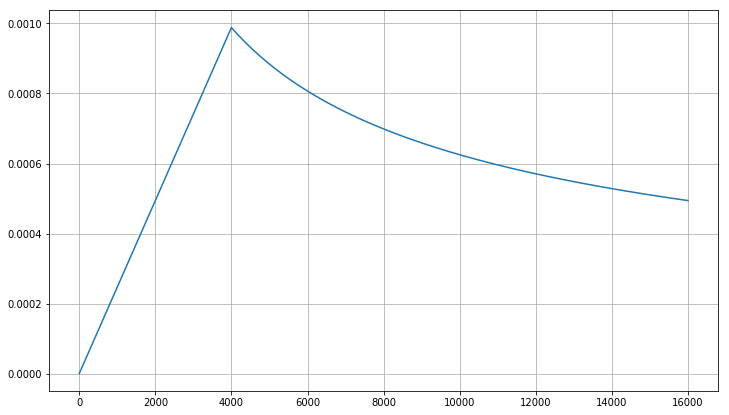

In [27]:
dmodel, warmupsteps = 256, 4000
lambda1 = lambda epoch: 1./np.sqrt(dmodel) * min(1./np.sqrt(epoch+1), (epoch+1) / warmupsteps / np.sqrt(warmupsteps))
grid = np.arange(warmupsteps*4)
values = list(map(lambda1, grid))

plt.figure(figsize=(12, 7))
plt.plot(grid, values)
plt.grid()
plt.show()

In [28]:
def get_vocab_mask(lang):
    vocab_mask = np.ones(len(lang))
    vocab_mask[lang['<unk>']] = 0
    return vocab_mask

def get_unk_idx(lang):
    return lang['<unk>']

vocab_mask = get_vocab_mask(de)
unk_idx = get_unk_idx(de)
vocab_mask.sum(), len(vocab_mask), unk_idx

(31796.0, 31797, 12566)

In [34]:
global_epoches = 1
inner_epoches = 8
batch_size = 128
epsls = 0.1
vocab_size = weights_matrix_de.shape[0]

model = Model(weights_matrix_en, weights_matrix_de, dmodel=dmodel, dk=dk, dv=dv, dff=dff)
optimizer = torch.optim.Adam(model.parameters(), lr=lambda1(0.), betas=(0.9, 0.98), eps=1e-9)
scheduler = LambdaLR(optimizer, lr_lambda=[lambda1])

# shuffle train dataset 
print('Shuffling train dataset ...')
en_train_sent, de_train_sent, en_train_lens, de_train_lens = shuffle(en_train_sent, de_train_sent, en_train_lens, de_train_lens)
print('Train dataset shuffled.')
# shuffle batches
batch_ix = np.arange(0, len(en_train_sent), batch_size)
np.random.shuffle(batch_ix)

running_loss = 0.0
running_accr = 0.0
losses, accrs = [], []
start_time = time.time()
for step in range(global_epoches * inner_epoches):
    ix = batch_ix[step % len(batch_ix)]
    batch_en, mask_en = get_batch(en_train_sent[ix:ix+batch_size], en_train_lens[ix:ix+batch_size])
    batch_de, mask_de = get_batch(de_train_sent[ix:ix+batch_size], de_train_lens[ix:ix+batch_size])
    
    batch_en, _, _ = to_one_hot(batch_en, mask_en, en)
    batch_de, batch_idx_de, mask_de = to_one_hot(batch_de, mask_de, de)
    batch_en, batch_de = torch.tensor(batch_en, dtype=torch.float32), torch.tensor(batch_de, dtype=torch.float32)
    mask_de = torch.tensor(mask_de[:, 1:], dtype=torch.float32)
    
    optimizer.zero_grad()
    outputs = model(batch_en, batch_de[:, :-1, :])
    
    # outputs.shape = (batch_size, length, vocab_size)
    smoothed_de = (1 - epsls) * batch_de[:, 1:, :] + epsls / vocab_size
    current = -outputs * smoothed_de
    # current.shape = (batch_size, length, vocab_size)
    current = torch.sum(current, 2)
    # mask_de.shape = (batch_size, length)
    # for not include loss for <unk> tokens and added in get_batch <end> tokens:
    current = current * mask_de
    loss = torch.sum(current) / torch.sum(mask_de)
          
    pred_values = torch.argmax(outputs, 2) #.shape = (batch_size, length)
    batch_idx_de = torch.tensor(batch_idx_de[:, 1:], dtype=torch.int64)
    curr = (pred_values == batch_idx_de) 
    # curr.shape - (batch_size, length)
    accr = torch.sum(curr.float() * mask_de) / torch.sum(mask_de)
        
    loss.backward()
    optimizer.step()
        
    running_loss += loss.item()
    running_accr += accr.item()
    
    if (step+1) % inner_epoches == 0: 
        end_time = time.time()
        running_loss /= inner_epoches
        running_accr /= inner_epoches
        losses.append(running_loss)
        accrs.append(running_accr)
        tm = end_time - start_time
        print('Step: %d/%d, train loss: %.4f, accuracy: %.4f, time: %.4f' % (step//inner_epoches, global_epoches, running_loss, running_accr, tm)) 
        running_loss, running_acr = 0., 0.
        scheduler.step()
        start_time = time.time()

Shuffling train dataset ...
Train dataset shuffled.
Step: 0/1, train loss: 8074.2236, accuracy: 0.0007, time: 202.4259
